## MAGNet Data

### Bulk RNA-seq

Data cleaning, outlier removal, etc.

Update 15.03.2021 (see https://redmine.dieterichlab.org/issues/1573)
- sample: keep all patients, except PPCM
- gene: standard filtering for gene based analyses


In [2]:
library(dplyr)
library(stringr)

library(loomR)

In [3]:
options(repr.plot.width=12, repr.plot.height=8)

In [4]:
# prep data

parentDir <- '/prj/MAGE'
dataDir <- file.path(parentDir, 'analysis', 'data', fsep=.Platform$file.sep)

ctsFile <- file.path(dataDir, 'stringtie', 'gene_count_matrix.csv', fsep=.Platform$file.sep)
traitsFile <- file.path(dataDir, 'MAGE_metadata.txt', fsep=.Platform$file.sep)
dedupFile <- file.path(parentDir, 'Christoph', 'mage_dedup_metrics_final.txt', fsep=.Platform$file.sep) # CD

cts <- read.csv(ctsFile, row.names="gene_id", as.is=T)
colnames(cts) <- gsub("_stringtieRef", "", colnames(cts))

In [5]:
datTraits <- read.csv(traitsFile, stringsAsFactors = FALSE)
datTraits <- datTraits[c('Run', 'etiology', 'race', 'Age', 'sex')]
colnames(datTraits) <- c('Run', 'Etiology', 'Race', 'Age', 'Sex')
datTraits <- datTraits[datTraits$Etiology != '',]
datTraits$Etiology <- str_sub(datTraits$Etiology, start = 1, end = 1)
datTraits[datTraits$Etiology=='D',]$Etiology <- 'DCM'
datTraits[datTraits$Etiology=='H',]$Etiology <- 'HCM'
datTraits[datTraits$Etiology=='N',]$Etiology <- 'NFD'
datTraits[datTraits$Etiology=='P',]$Etiology <- 'PPCM'
datTraits$Etiology <- relevel(as.factor(datTraits$Etiology), ref='NFD')
datTraits[datTraits$Race=='African American',]$Race <- 'AA'
datTraits[datTraits$Race=='Caucasian',]$Race <- 'C'
datTraits$Race <- relevel(as.factor(datTraits$Race), ref='C')
datTraits[datTraits$Sex=='female',]$Sex <- 'F'
datTraits[datTraits$Sex=='male',]$Sex <- 'M'
datTraits$Sex <- relevel(as.factor(datTraits$Sex), ref='M')

In [6]:
idx <- intersect(datTraits$Run, colnames(cts))
datTraits <- datTraits[na.omit(match(idx, datTraits$Run)),]
cts <- cts[,na.omit(match(idx, colnames(cts)))]

dedup <- read.table(dedupFile, as.is=T, header=F)
dedup <- dedup[,c(1,3)]
dedup[,1] <- gsub(".metrics.txt-Unknown","", dedup[,1])
colnames(dedup) <- c("Run","DuplicationRate")
datTraits <- merge(datTraits, dedup, by.x='Run', by.y='Run')
rownames(datTraits) <- datTraits$Run

ins <- intersect(rownames(datTraits), colnames(cts))
datTraits <- datTraits[ins, ]
cts <- cts[, ins]

# stopifnot(all(datTraits$Run == colnames(cts)))
all(rownames(datTraits)==colnames(cts))

[1] TRUE

In [7]:
dim(cts)

[1] 58884   360

In [9]:
# gene-level filtering

varQuant <- 0.01
countQuant <- 0.01

# raw threshold
chk <- cts[rowSums(cts) > 10, ]
# threshold on variance: remove varQuant% of genes with lowest variance
var.all <- apply(chk, 1, var)
chk <- chk[var.all > quantile(var.all, probs=varQuant, type=8), ]
# threshold on normalised counts: remove countQuant% of genes with lowest
# (sequencing-depth normalised) average expression
sf <- DESeq2::estimateSizeFactorsForMatrix(chk)
chk.norm <- t(t(chk)/sf)
keep <- rowMeans(chk.norm) > quantile(rowMeans(chk.norm), probs=countQuant, type=8)
chk <- chk[keep,]

background <- rownames(cts)
universe <- background %in% background
selection <- background %in% rownames(chk)
genes <- factor(as.integer(selection[universe]))
names(genes) <- background

dim(chk)

[1] 41886   360

In [10]:
# sample-level filtering (no outlier removal)
# remove PPCM only

samples <- rep(1, dim(cts)[2])
names(samples) <- colnames(cts)
samples[names(samples) %in% datTraits[datTraits$Etiology == 'PPCM',]$Run] <- 0
samples <- as.factor(samples)


In [12]:
# write loom file
gene.attrs <- list(GeneFlag=genes)
cell.attrs <- list(SampleFlag=samples,
                   Run=datTraits$Run,
                   Etiology=datTraits$Etiology,
                   Race=datTraits$Race,
                   Age=datTraits$Age,
                   Sex=datTraits$Sex,
                   DuplicationRate=datTraits$DuplicationRate)

filename <- file.path(dataDir, 'stringtie', 'MAGNet_data.loom', fsep=.Platform$file.sep)
create(filename, 
       cts, 
       gene.attrs=gene.attrs, 
       cell.attrs=cell.attrs,
       do.transpose=TRUE,
       calc.numi=FALSE)

# ISSUE: https://github.com/mojaveazure/loomR/issues/38
# we already have installed the latest dev version...
# write loom file, add gene flag separately, and re-create with loompy
# save anyway genes and patients

write.table(genes, file.path(dataDir, 'stringtie', 'genes.txt'), 
            row.names=T, col.names=F, quote=F, sep=",")

# import os
# import pandas as pd
# import loompy as lp
# dataloc = '/prj/MAGE/analysis/data/stringtie'
# lf = lp.connect(os.path.join(dataloc, 'MAGNet_data.loom'), mode='r+', validate=False)
# x = pd.read_csv(os.path.join(dataloc, 'genes.txt'), index_col=0, header=None, names=['x'])
# row_attrs = {}
# for key, value in lf.ra.items():
#     row_attrs[key] = value
# row_attrs['GeneFlag'] = x['x'].values
# col_attrs = {}
# for key, value in lf.ca.items():
#     col_attrs[key] = value
# data = lf[:,:]
# lf.close()
# lp.create(os.path.join(dataloc, 'MAGNet_data.loom'),
#     data, 
#     row_attrs=row_attrs, 
#     col_attrs=col_attrs)


Transposing input data: loom file will show input columns (cells) as rows and input rows (features) as columns

This is to maintain compatibility with other loom tools



  |======================================================================| 100%


Adding: CellID

Adding: Gene

Adding: SampleFlag

Adding: Run

Adding: Etiology

Adding: Race

Adding: Age

Adding: Sex

Adding: DuplicationRate



Class: loom
Filename: /beegfs/prj/MAGE/analysis/data/stringtie/MAGNet_data.loom
Access type: H5F_ACC_RDWR
Attributes: version, chunks, LOOM_SPEC_VERSION, last_modified
Listing:
       name    obj_type dataset.dims dataset.type_class
  col_attrs   H5I_GROUP         <NA>               <NA>
 col_graphs   H5I_GROUP         <NA>               <NA>
     layers   H5I_GROUP         <NA>               <NA>
     matrix H5I_DATASET  360 x 58884        H5T_INTEGER
  row_attrs   H5I_GROUP         <NA>               <NA>
 row_graphs   H5I_GROUP         <NA>               <NA>

In [13]:
lfile <- connect(filename=file.path(dataDir, 'stringtie', 'MAGNet_data.loom'), mode="r+", skip.validate=TRUE)
lfile
lfile$close_all()

Warning message in initialize(...):
“Skipping validation step, some fields are not populated”


Class: loom
Filename: /beegfs/prj/MAGE/analysis/data/stringtie/MAGNet_data.loom
Access type: H5F_ACC_RDWR
Attributes: version, chunks, LOOM_SPEC_VERSION, last_modified
Listing:
       name    obj_type dataset.dims dataset.type_class
  col_attrs   H5I_GROUP         <NA>               <NA>
 col_graphs   H5I_GROUP         <NA>               <NA>
     layers   H5I_GROUP         <NA>               <NA>
     matrix H5I_DATASET  360 x 58884        H5T_INTEGER
  row_attrs   H5I_GROUP         <NA>               <NA>
 row_graphs   H5I_GROUP         <NA>               <NA>

In [14]:
# add as RData 
save(cts, cell.attrs, gene.attrs, file=file.path(dataDir, 'stringtie', 'MAGNet_data.RData'))


In [20]:
# write sample info - metadata 
write.table(as.data.frame(cell.attrs)[c(2,1,3,4,5,6,7)], file.path(dataDir, 'stringtie', 'samples.txt'), 
            row.names=F, col.names=T, quote=F, sep=",")

In [ ]:
# ############################################################################################################
# sample analysis

In [46]:
library(ggplot2)
library("RColorBrewer")

plot_pca <- function(datExpr, datTraits) {  
    # in case we have zero variance for some genes...
    tt <- t(datExpr)
    d1 <- dim(tt)[2]
    tt <- tt[ , apply(tt, 2, var) != 0]
    d2 <- dim(tt)[2]
    if (d1 != d2) {
        print(paste("Removed ", d1-d2, "genes with zero variance before PCA", sep=""))
    }
    pcaData <- prcomp(tt, scale=T)
    # determine the proportion of variance of each component
    percentVar <- round(100*pcaData$sdev^2/sum(pcaData$sdev^2), 1)
    # create data frame
    pca.df <- data.frame(pc1=pcaData$x[,1], 
                         pc2=pcaData$x[,2],
                         datTraits[,c('Race', 'Age', 'Sex', 'Etiology')])
    # age as factor
    pca.df$qage <- cut(pca.df$Age, 
                       breaks = quantile(pca.df$Age, by=0.25), 
                       include.lowest = TRUE)
    d <- tidyr::pivot_longer(pca.df, cols = c('Race', 'Sex', 'qage', 'Etiology'), names_to='traits')

    ggplot(data=d, aes_string(x='pc1', y='pc2', color='value')) + 
        geom_point(size=2) + 
        xlab(paste0("PC1: explaining ", percentVar[1], "% of variance")) +
        ylab(paste0("PC2: explaining ", percentVar[2], "% of variance")) +
        facet_wrap(~traits) +
        theme_linedraw()
}

In [22]:
# rlog is more robust and sometimes performs qualitatively better than the vst which is useful 
# when checking for outliers, e.g. more false positive outliers were reported by PcaGrid when 
# vst was used for normalization than when rlog transformation was used.
# However, rlog is significantly slower with many samples...
# the vst speed-up is accomplished by subsetting to a smaller number of genes to estimate
# the dispersion trend

# It uses the design formula to calculate the within-group variability (if blind=FALSE) or the 
# across-all-samples variability (if blind=TRUE). 

cts <- as.matrix(cts)
cts_vst <- DESeq2::vst(cts, blind=TRUE) # increase nsub ?


[1] "Removed 8147genes with zero variance before PCA"


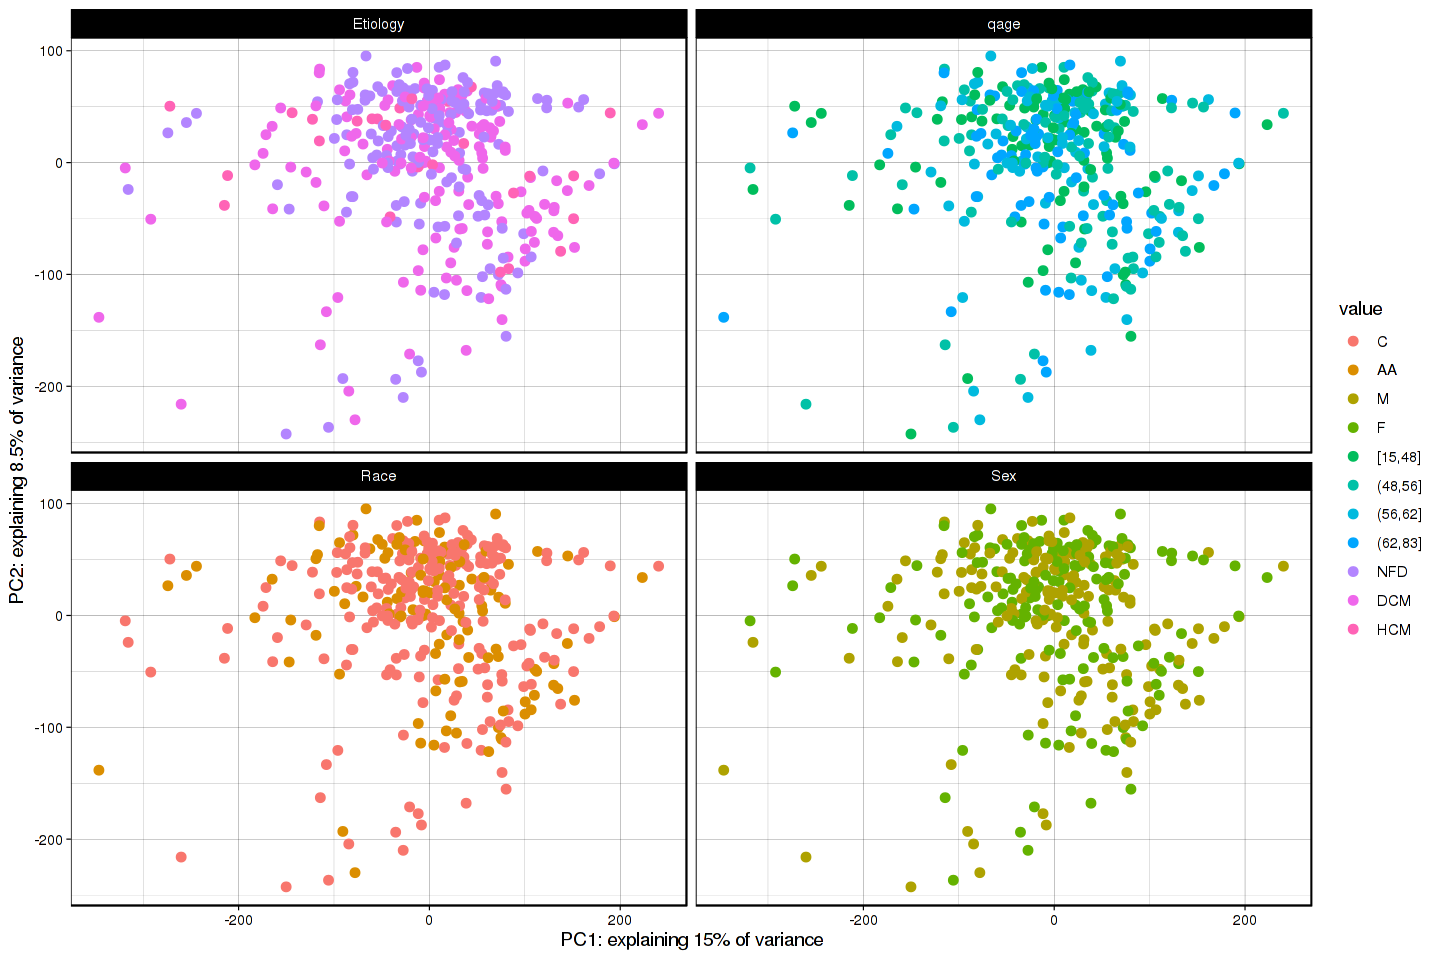

In [47]:
plot_pca(cts[,as.logical(as.numeric(as.numeric(levels(cell.attrs$SampleFlag))[cell.attrs$SampleFlag]))], 
         datTraits[!(rownames(datTraits) %in% datTraits[datTraits$Etiology == 'PPCM',]$Run),])

In [156]:
# import umap
# import pandas as pd

# import seaborn as sns
# import matplotlib.pyplot as plt

# runUmap = umap.UMAP(n_neighbors=15, 
#                     min_dist=0.5, 
#                     n_components=2,
#                     metric='euclidean').fit_transform

# cts = pd.read_csv(os.path.join(dataDir, 'cts_vst.csv'), index_col=0)
# meta = pd.read_csv(os.path.join(dataDir, 'meta.csv'), index_col=0)
# dr_umap = runUmap(cts.T)
# dr_umap = pd.DataFrame(dr_umap, columns=['X', 'Y'], index=list(cts))

# fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,8), dpi=150)

# drplot(dr_umap, colorlab=meta['Etiology'], ax=ax1, s=2, title='Etiology')
# drplot(dr_umap, colorlab=meta['Race'], ax=ax2, s=2, title='Race')
# drplot(dr_umap, colorlab=meta['Sex'], ax=ax3, s=2, title='Sex')

# ax1.legend(loc='right', bbox_to_anchor=(1.25, 0.15), ncol=1, markerscale=2,
#            fontsize='x-large', frameon=False, title=None)
# fig.tight_layout()
# fig.savefig(os.path.join(dataDir, 'umap_all.pdf') , dpi=600, bbox_inches='tight')


In [48]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

Matrix products: default
BLAS:   /beegfs/biosw/R/3.6.2/lib/R/lib/libRblas.so
LAPACK: /beegfs/biosw/R/3.6.2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_IE.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_IE.UTF-8        LC_COLLATE=en_IE.UTF-8    
 [5] LC_MONETARY=en_IE.UTF-8    LC_MESSAGES=en_IE.UTF-8   
 [7] LC_PAPER=en_IE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_IE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RColorBrewer_1.1-2 ggplot2_3.3.3      loomR_0.2.1.9000   hdf5r_1.3.3       
[5] R6_2.5.0           stringr_1.4.0      dplyr_1.0.5       

loaded via a namespace (and not attached):
 [1] bitops_1.0-6                matrixStats_0.58.0         
 [3] bit64_4.0.5       